# FIFA 17

CUNY Web Analytics

July 2018

** Group 3 Members:**

* Rafal Decowski 

* Tze Fung Lung  

* Yun Mai

* Ahsanul Choudhury


** Project Objectives **

1.	Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2.	Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3.	What can you infer about each of the distinct groups?


**Data **

[FIFA 2017 - The Game](https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset)


FIFA 17 is a sports video game in the FIFA series developed and published by Electronic Arts, that was released in September 2016. 


** Objective **

Narrow down the best players, observe their club affiliations and perform in-depth study on their performance, salary, monetary value and their contribution in the 2018 World Cup.




In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data


There are **16,961 unique players** out of 17,965 total records. Some of the players appear multiple times as FIFA tracks the notable players throughout their careers. 

** Features **
- Name of a player
- Age of a player
- Player's Nationality
- Overall Performance Score
- Potential Performance Score
- The international club for which the player plays
- Value
- Wage
- Preferred Positions



In [2]:
# Load Data into Pandas dataframes
fifa = pd.read_csv('D:\\Rafal\\CUNY\\620\\hw\\hw4\\data\\fifa_players_utf.csv')
fifa.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
0,M. Romeo,21,Antigua & Barbuda,65,76,Millwall,800K,7K,RB
1,A. Laporte,23,France,84,89,Athletic Club de Bilbao,35.5M,36K,CB
2,C. Jahraldo-Martin,24,Antigua & Barbuda,60,66,Newport County,280K,1K,ST RM LM
3,A. Gómez,29,Argentina,84,84,Atalanta,31M,60K,ST LW CF
4,Aduriz,36,Spain,84,84,Athletic Club de Bilbao,11M,38K,ST


In [3]:
# Drop any rows that have missing values
fifa = fifa.dropna()

# Networkx Graph


We will use players as one set of nodes and clubs as the other. This should lead us to a bipartite graph.

The edges mark which players play for which clubs. In addition, there is a weight associated with every edge. The weight represents the overall performance of the player for the connected club.
The weights will be later used to 'raise the water levels' within the network and create multiple islands. This will lead us to one or two islands with the highest performing plaers and their clubs.

In [4]:
# Networkx graph with two sets of bipartite nodes
B = nx.Graph()
B.add_nodes_from(fifa['Name'], bipartite=0)
B.add_nodes_from(fifa['Club'], bipartite=1)

# Extract data from the main dataframe and add as weighted edges
weighted_edges = fifa[['Name', 'Club','Overall']].T.apply(tuple).tolist()
B.add_weighted_edges_from(weighted_edges)

Since there are so many players and clubs, the graph does not fully connect. The cell below captures the largest connected component that we will continue to study. 

In [5]:
# Capture Biggest connected graph and test
B = max(nx.connected_component_subgraphs(B), key=len)
nx.is_connected(B)

True

Capture all player and nodes from the graph.

This will be used to color code players and clubs for improved visuals.

In [6]:
player_nodes = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
club_nodes = set(B) - player_nodes

# Island method

In [7]:
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
            
    return g2

In [8]:
def island_method(g, iterations=6):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [9]:
cc = sorted(nx.connected_component_subgraphs(B), key = len, reverse=True)[0]
#    sorted(nx.connected_component_subgraphs(team_win), key = len, reverse=True)[0]
islands = island_method(cc)
 
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0], len(i[1]), len(sorted(nx.connected_component_subgraphs(i[1]), key = len, reverse=True)))

46 13291 1
54 12573 13
62 9592 114
70 4028 281
78 716 97
86 59 14


We performed 6 iterations on the biggest connected graph from the entire dataset. 
This lead us to 6 _islands_ each containing smaller number of players but of higher overall performance. 

** Edge Weight = Player Performance Score (_Overall_)**


We will visualize only on the last two, and conduct an in-depth analysis on **the smallest island with 59 nodes total, 45 players and 14 clubs.**



# Graph Visualization


First attempt in visualizing the 2nd-to-smallest island with 716 total nodes. The picture may render hard to read. This should improve with moving onto the smallest island.

- **Blue = Player**
- **Green = Club**
- **Node Size = Degree**

## 2nd Smallest Island Visualization

In [10]:
# Create a list of colors based on the node name (players vs clubs)

node_colors = []
for n in islands[4][1].nodes(data=True):
    if n[0] in player_nodes:
        node_colors.append('#3366ff')
    else:
        node_colors.append('#40bf80')

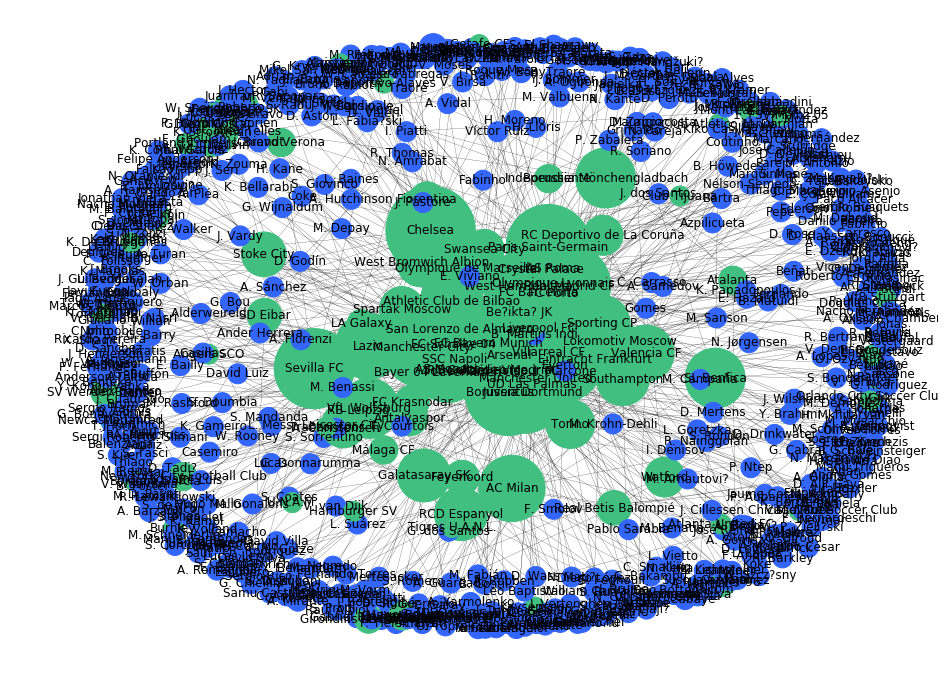

In [11]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[4][1], k=2) # k=2 values helps spread the nodes

# Degree calculations to denote the size of nodes
degree = dict(nx.degree(islands[4][1]))


degree_graph = nx.draw_networkx(islands[4][1], 
                                pos=pos,
                                node_color=node_colors,
                                node_size=np.multiply(list(degree.values()), 400), # multiply degree by 400 for better resolution
                                with_labels=True, 
                                width=0.2)

# Remove axis
limits=plt.axis('off')

## Smallest Island Visualization

In [12]:
node_colors = []

for n in islands[5][1].nodes(data=True):
    if n[0] in player_nodes:
        node_colors.append('#3366ff')
    else:
        node_colors.append('#40bf80')

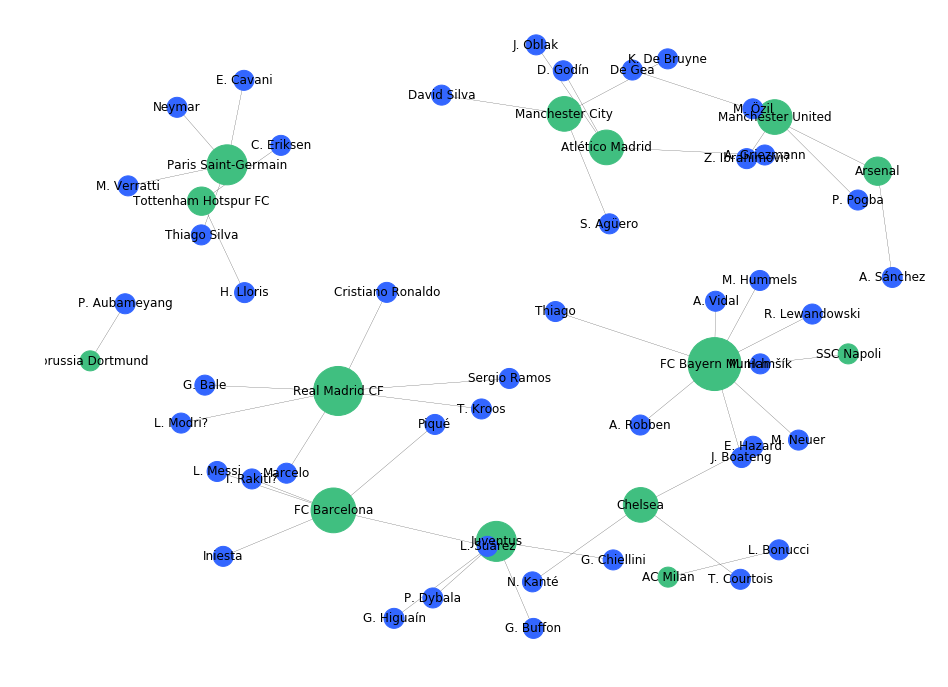

In [13]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[5][1], k=2)

degree = dict(nx.degree(islands[5][1]))

degree_graph = nx.draw_networkx(islands[5][1], 
                                pos=pos,
                                node_color=node_colors,
                                #edge_color='#b3b3b3',   
                                node_size=np.multiply(list(degree.values()), 400), 
                                with_labels=True, 
                                width=0.2)

# remove axis
limits=plt.axis('off')

In the graph above we can see some of the most renowned clubs and players.
Very few of the players in the graph played for more than one of the listed clubs. 

# Indepth analysis of the best players, their clubs and nationalities

In [14]:
best_players = fifa[fifa.Name.isin(list(islands[5][1].nodes()))]
best_players[best_players.Name == 'L. Suárez']

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
9306,L. Suárez,22,Argentina,64,73,Defensa y Justicia,600K,3K,LB
17093,L. Suárez,30,Uruguay,92,92,FC Barcelona,97M,510K,ST
17241,L. Suárez,21,Argentina,70,81,Villarreal CF,3.1M,16K,LM RM


Notice there are some players showing up multiple times. That's because we extracted the players from the original dataset and FIFA tracked their career with multiple clubs.

We will keep only the entry at their **peak** overall performance. 

In [15]:
best_players = best_players.groupby('Name', group_keys=False).apply(lambda x: x.loc[x.Overall.idxmax()])
best_players[best_players.Name == 'L. Suárez']

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
Name,,,,,,,,,
L. Suárez,L. Suárez,30,Uruguay,92,92,FC Barcelona,97M,510K,ST


## Count of High Quality Players by Nationality

It is no surprise that the teams that are usually top contenders in the World Cup 'produce' the most players with exceptional skill and talent.

Since we are approaching the 2018 World Cup Final, the finalists are marked in orange for an easy comparison.  

Text(0.5,0,'Count of High Quality Players')

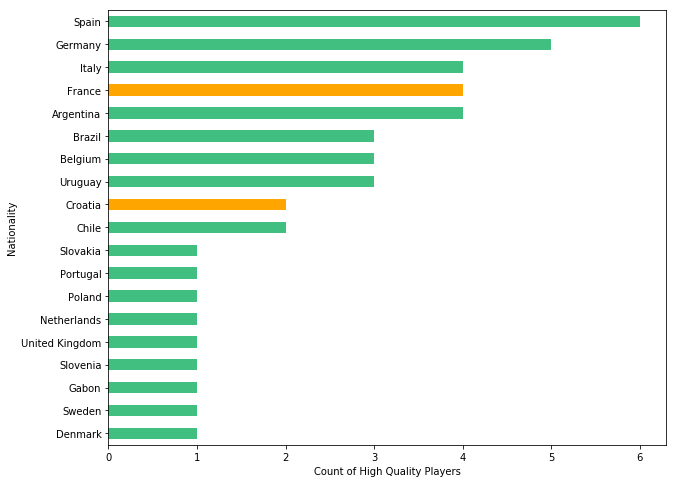

In [16]:
plt.rcParams['figure.figsize'] = [10, 8]
best_players.groupby('Nationality')\
    .count().Overall\
    .sort_values(ascending=True)\
    .plot(kind='barh', color=[np.where([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1], 'orange', '#40bf80')])

plt.xlabel('Count of High Quality Players')

## Average Age of Best Players by Nationality

For many players, their professional career starts as early as the age of 16. Even though we are studying only the best 45 players, and the chart below may not be statistically significant to reflect a national trend, it is important to note that a difference of 10 years between best players of Sweden and Slovenia is remarkable because ** the average duration of playing career is 8 years.**


Text(0.5,0,'Average Age')

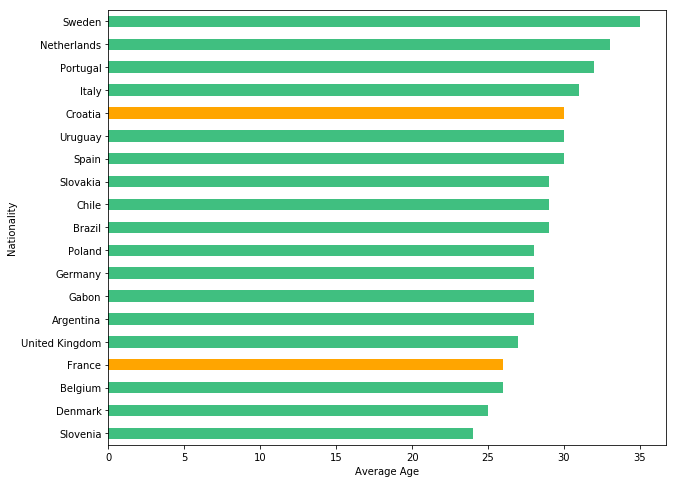

In [17]:
plt.rcParams['figure.figsize'] = [10, 8]

best_players.groupby('Nationality')\
    .mean()\
    .Age.round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', color=[np.where([0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0], 'orange', '#40bf80')])
    
plt.xlabel('Average Age')

## Players'  monetary Value and Wage

Before we get to the charting, we first need to convert the value and wage into numerical type. They are initially represented with M for Millions and K for Thousands. 

All values are in Euro.

In [18]:
# Convert M into numberic millions and K into numeric thousands
best_players.Value = (best_players.Value.replace(r'[KM]+$', '', regex=True).astype(float) * \
                      best_players.Value.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1)
                      .replace(['K','M'], [10**3, 10**6]).astype(int))

best_players.Wage = (best_players.Wage.replace(r'[KM]+$', '', regex=True).astype(float) * \
                     best_players.Wage.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1)
                     .replace(['K','M'], [10**3, 10**6]).astype(int))


In [19]:
best_players.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
Name,,,,,,,,,
A. Griezmann,A. Griezmann,26,France,88,91,Atlético Madrid,75000000.0,150000.0,LW RW ST
A. Robben,A. Robben,33,Netherlands,88,88,FC Bayern Munich,36000000.0,225000.0,RW RM
A. Sánchez,A. Sánchez,28,Chile,89,89,Arsenal,67500000.0,265000.0,RM LW ST LM
A. Vidal,A. Vidal,30,Chile,87,87,FC Bayern Munich,37500000.0,160000.0,CM CDM
C. Eriksen,C. Eriksen,25,Denmark,87,91,Tottenham Hotspur FC,65000000.0,165000.0,LM RM CAM


## Average Wage (in Thousands of Euros) by Club

There seems to be a correlation between clubs that pay their players the most and the clubs' rank and achievements. 
Spanish, English, German, French and Italian clubs pay the highest salaries. 


Text(0.5,0,'Average Wage (in Thousands of Euros)')

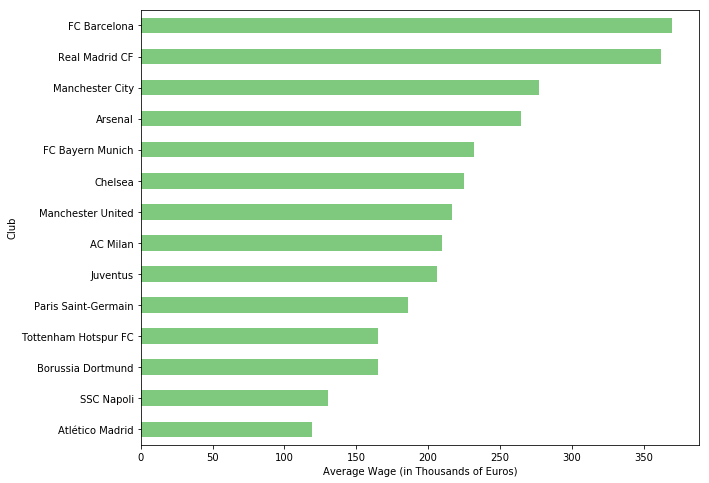

In [20]:
plt.rcParams['figure.figsize'] = [10, 8]
best_players.groupby('Club')\
    .mean().Wage\
    .apply(lambda x: x/1000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')

plt.xlabel('Average Wage (in Thousands of Euros)')

## Clubs with the Most Valuable ($) players 

Paris Sait-Germain is the team with 4 high quality players and they are valued the most on average. Chealsea is right behind with 3 players and Real Madrit has 6. 


In [21]:
best_players.groupby('Club').count()

,Name,Age,Nationality,Overall,Potential,Value,Wage,Preferred Positions
Club,,,,,,,,
AC Milan,1,1,1,1,1,1,1,1
Arsenal,2,2,2,2,2,2,2,2
Atlético Madrid,3,3,3,3,3,3,3,3
Borussia Dortmund,1,1,1,1,1,1,1,1
Chelsea,3,3,3,3,3,3,3,3
FC Barcelona,5,5,5,5,5,5,5,5
FC Bayern Munich,7,7,7,7,7,7,7,7
Juventus,4,4,4,4,4,4,4,4
Manchester City,3,3,3,3,3,3,3,3


Text(0.5,0,'Average Value (in Millions of Euros)')

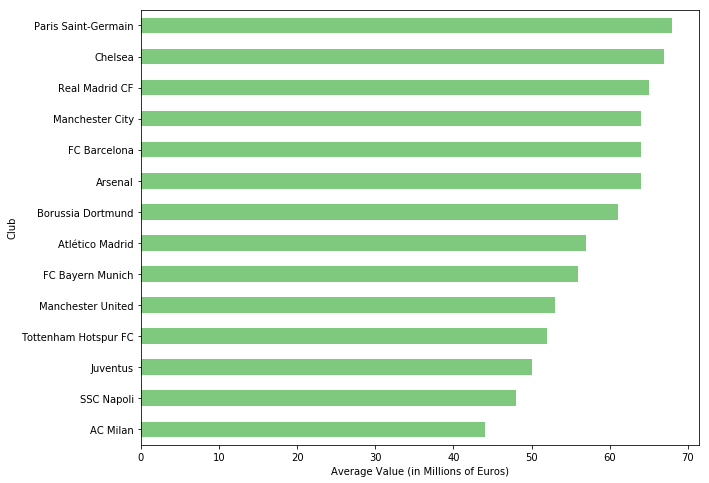

In [22]:
plt.rcParams['figure.figsize'] = [10, 8]

best_players.groupby('Club').mean().Value\
    .apply(lambda x: x/1000000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')

plt.xlabel('Average Value (in Millions of Euros)')

Since the above chart shows the average value for all players, it may be more informative to check the total (sum) value of all the best players. 

As suspected, Real Madrit moves above PSG and Chealsea but Bayern Munich shoots up with their 7 top players and their total value of **393,000,000 Euro!**

Text(0.5,0,'Average Value (in Millions of Euros)')

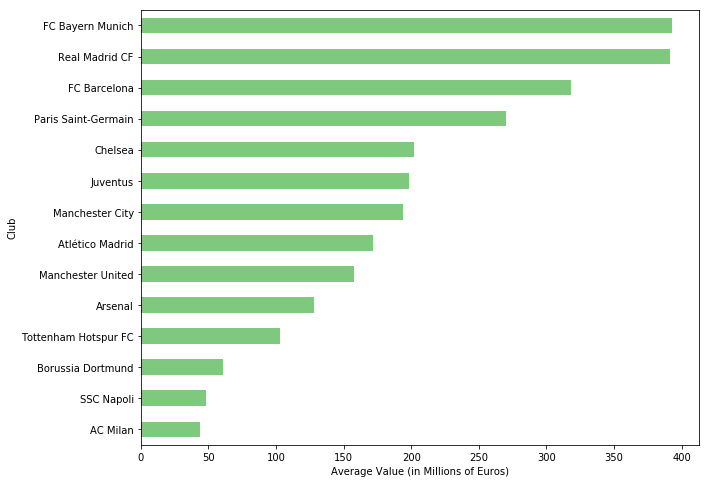

In [23]:
plt.rcParams['figure.figsize'] = [10, 8]

best_players.groupby('Club').sum().Value\
    .apply(lambda x: x/1000000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')

plt.xlabel('Average Value (in Millions of Euros)')

**FIFA Position acronyms**

    GK: Goalkeeper
    CB: Center-back
    LCB: Left center-back
    RCB: Right center-back
    LB: Left-back (Full-back)
    RB: Right-back (Full-back)

    CM : Centre midfield
    LDM: Left center midfield
    LAM: Left attacking midfield
    RDM: Right center midfield
    RAM: Right attacking midfield
    CDM: Centre defensive midfield
    CAM: Centre attacking midfield
    LM : Left midfield
    RM : Right midfield

    ST: Striker
    CF: Center forward
    LW: Left winger
    RW: Right winger

## Best paid field positions


**It is clear that both forward wings (R,L) and center striker are the best paid field positions.**

Text(0.5,0,'Average Wage (in Thousands of Euros)')

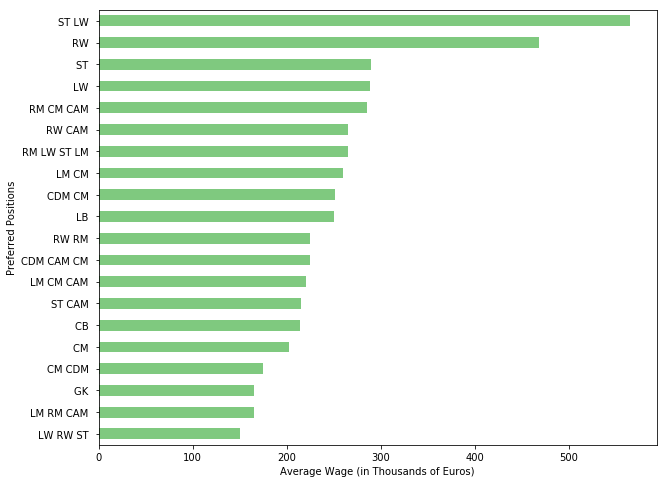

In [24]:

best_players.groupby('Preferred Positions').mean().Wage\
    .apply(lambda x: x/1000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')
    
    
plt.xlabel('Average Wage (in Thousands of Euros)')


## Overall Performance vs Potential

We will create a new feature that captures the difference between these two, _Growth_.

The table shows us some upcoming stars (even bigger) from Slovenia, Argentina and France.
It would be advisable for club managers to continue to watch their development and consider transfers.
Notice the much lower salary of J.Oblak from other players of similar performance. It looks like he would be open to negotiations.


In [25]:
best_players['Growth'] = best_players.Potential - best_players.Overall

best_players.nlargest(10, 'Growth')

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions,Growth
Name,,,,,,,,,,
J. Oblak,J. Oblak,24,Slovenia,88,93,Atlético Madrid,57000000.0,82000.0,GK,5
P. Dybala,P. Dybala,23,Argentina,88,93,Juventus,79000000.0,215000.0,ST CAM,5
P. Pogba,P. Pogba,24,France,87,92,Manchester United,66500000.0,195000.0,CDM CM,5
C. Eriksen,C. Eriksen,25,Denmark,87,91,Tottenham Hotspur FC,65000000.0,165000.0,LM RM CAM,4
M. Verratti,M. Verratti,24,Italy,87,91,Paris Saint-Germain,64500000.0,130000.0,CDM CM,4
A. Griezmann,A. Griezmann,26,France,88,91,Atlético Madrid,75000000.0,150000.0,LW RW ST,3
K. De Bruyne,K. De Bruyne,26,Belgium,89,92,Manchester City,83000000.0,285000.0,RM CM CAM,3
N. Kanté,N. Kanté,26,France,87,90,Chelsea,52500000.0,190000.0,CM CDM,3
T. Courtois,T. Courtois,25,Belgium,89,92,Chelsea,59000000.0,190000.0,GK,3


## Countries with the most room for improvements

France takes the first place in terms of potential growth with 11 points total for all their players. Belgium takes the second place with 7 points. Both teams are top contenders in the World Cup. 

On Sunday 7/15/2018 France will face the underestimated Croatia. Perhaps after the tournament FIFA will reevaluate Croatian players and their hidden potential.


In [26]:
best_players.groupby('Nationality').sum().Growth.sort_values(ascending=False)

Nationality
France            11
Belgium            7
Argentina          5
Slovenia           5
Denmark            4
Italy              4
Spain              4
Brazil             2
Portugal           0
Poland             0
Netherlands        0
United Kingdom     0
Germany            0
Gabon              0
Slovakia           0
Croatia            0
Chile              0
Sweden             0
Uruguay            0
Name: Growth, dtype: int64